In [ ]:
%pip install -q huggingface_hub open_clip_torch

In [ ]:
!git clone https://github.com/ChenDelong1999/RemoteCLIP/ --depth 1

In [1]:
from os.path import join

from huggingface_hub import hf_hub_download
import torch, open_clip
from PIL import Image
from IPython.display import display

In [2]:
# for model_name in ['RN50', 'ViT-B-32', 'ViT-L-14']: #all models
#     checkpoint_path = hf_hub_download('chendelong/RemoteCLIP', f'RemoteCLIP-{model_name}.pt', cache_dir='checkpoints')
#     print(f'{model_name} is downloaded to {checkpoint_path}.')

In [2]:
# model_name = 'RN50'
# model_name = 'ViT-B-32'
model_name = 'ViT-L-14'
model, _, preprocess = open_clip.create_model_and_transforms(model_name)
tokenizer = open_clip.get_tokenizer(model_name)

print('#params: ', f'{sum(p.numel() for p in model.parameters()):,}')

#params:  427,616,513


In [3]:
checkpoints_dir = 'checkpoints/models--chendelong--RemoteCLIP/snapshots/bf1d8a3ccf2ddbf7c875705e46373bfe542bce38'

ckpt = torch.load(join(checkpoints_dir, f'RemoteCLIP-{model_name}.pt'))
message = model.load_state_dict(ckpt)
model = model.cuda().eval()

---

In [4]:
from rastervision.core.box import Box
from rastervision.core.data import RasterioSource, StatsTransformer
from rastervision.pytorch_learner.dataset import (
    SemanticSegmentationSlidingWindowGeoDataset)

from tqdm.auto import tqdm
import albumentations as A
import numpy as np
import torch
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
sns.reset_defaults()

In [5]:
def show_windows(img, windows, scores, figsize, title=''):
    plt.close('all')
    fig, ax = plt.subplots(1, 1, squeeze=True, figsize=figsize)
    ax.imshow(img)
    ax.axis('off')
    # draw windows on top of the image
    for w, score in zip(windows, scores):
        p = patches.Polygon(w.to_points(), color='r', alpha=score * 0.5, linewidth=1)
        ax.add_patch(p)
    ax.autoscale()
    ax.set_title(title)
    plt.show()

def show_top_chips(chip_scores, raster_source, windows, nrows=5, ncols=5, figsize=(12, 12), w_pad=-2.5, h_pad=-2.5):
    fig, axs = plt.subplots(nrows, ncols, figsize=figsize)
    fig.tight_layout(w_pad=w_pad, h_pad=h_pad)
    top_inds = torch.topk(chip_scores, axs.size).indices
    for ax, ind in zip(axs.flat, top_inds):
        chip = raster_source.get_chip(windows[ind])
        ax.imshow(chip)
        ax.axis('off')
    plt.show()

In [11]:
import pystac_client
from shapely.geometry import mapping

bbox = Box(39.96, -75.17, 39.96, -75.13)
catalog = pystac_client.Client.open('https://earth-search.aws.element84.com/v1')
bbox_geometry = mapping(bbox.to_shapely().oriented_envelope)
item = catalog.search(
    intersects=bbox_geometry,
    collections=['sentinel-2-l2a'],
    datetime='2024-02-04',
    query={'eo:cloud_cover': {
        'lt': 5
    }},
).get_all_items()[-1]
item

<Item id=S2B_18TVK_20240204_0_L2A>

In [9]:
from rastervision.core.data import Scene, XarraySource
from rastervision.core.data.raster_source.stac_config import subset_assets

In [12]:
item = subset_assets(item, ['red', 'green', 'blue'])
rs_stats = XarraySource.from_stac(
    item,
    allow_streaming=False,
)
stats_tf = StatsTransformer.from_raster_sources([rs_stats])

2024-03-08 22:12:15:rastervision.core.data.raster_source.xarray_source: INFO - Loading the full DataArray into memory (2.9 GB).
INFO:rastervision.core.data.raster_source.xarray_source:Loading the full DataArray into memory (2.9 GB).


Analyzing chips: 0it [00:00, ?it/s]

In [13]:
rs = XarraySource(
    rs_stats.data_array,
    crs_transformer=rs_stats.crs_transformer,
    raster_transformers=[stats_tf],
    temporal=False
)
rs.shape

(10980, 10980, 3)

In [10]:
# img = rs[:, :]
# img.shape

(10980, 10980, 3)

In [14]:
scene = Scene('', raster_source=rs)
ds = SemanticSegmentationSlidingWindowGeoDataset(
    scene,
    size=400,
    stride=400,
    padding=0,
    transform=A.Resize(224, 224),
)
dl = DataLoader(ds, batch_size=8)
len(ds)

729

In [12]:
embs = []
with torch.inference_mode(), tqdm(dl, desc='Creating chip embeddings') as bar:
    for x, _ in bar:
        x = x.cuda()
        _emb_1 = model.encode_image(x)
        _emb_2 = model.encode_image(x.flip(2))
        _emb_3 = model.encode_image(x.flip(3))
        _emb_4 = model.encode_image(x.flip(2).flip(3))
        emb = sum([_emb_1, _emb_2, _emb_3, _emb_4]) / 4
        # emb = model.encode_image(x)
        embs.append(emb.cpu())
embs = torch.cat(embs, dim=0)
embs /= embs.norm(dim=-1, keepdim=True)
embs.shape

Creating chip embeddings:   0%|          | 0/92 [00:00<?, ?it/s]

torch.Size([729, 768])

In [13]:
torch.save(embs, 'RemoteCLIP_s2_embeddings_400_200.pt')

In [6]:
embs = torch.load('RemoteCLIP_s2_embeddings_400_200.pt')
embs.shape

torch.Size([729, 768])

In [7]:
model = model.cpu()
torch.cuda.empty_cache()

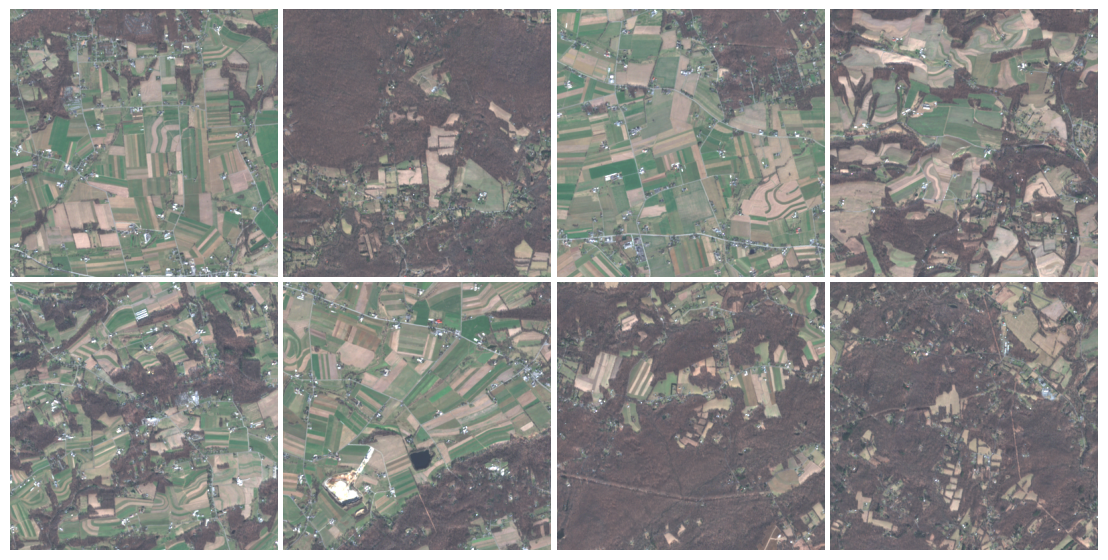

In [30]:
T = 0.01
text_queries = [
    'agricultural land',
    # 'river',
    # 'barren land',
    # 'a long bridge over a large body of water',
    # 'airport',
    # 'stadium',
    # 'warehouses',
    # 'storage tanks',
    # 'power plant',
]
assert len(text_queries) == 1
text = tokenizer(text_queries)
with torch.inference_mode():
    text_features = model.encode_text(text)
    text_features /= text_features.norm(dim=-1, keepdim=True)
    text_features = text_features.cpu()
    chip_scores = torch.cosine_similarity(text_features, embs)
    # chip_scores = (chip_scores / T).softmax(dim=0)
    # chip_scores = chip_scores / chip_scores.max()

# show_windows(img, ds.windows, chip_scores, figsize=(10, 10))
show_top_chips(chip_scores, rs, ds.windows, nrows=2, ncols=4, figsize=(12, 6), w_pad=-5.5, h_pad=-1.75)

In [ ]:
plt.hist(chip_scores, bins=30)
plt.show()

---

In [ ]:
from rastervision.pipeline.file_system.utils import json_to_file
from rastervision.core.data import ClassConfig, boxes_to_geojson

In [ ]:
geojson = boxes_to_geojson(ds.windows, [0] * len(ds), rs.crs_transformer, ClassConfig(names=['airport']), scores=chip_scores.tolist())

# json_to_file(geojson, 'RemoteCLIP_airport_detections.json')
# json_to_file(geojson, 'RemoteCLIP_stadium_detections.json')
# json_to_file(geojson, 'RemoteCLIP_bridge_detections.json')
# json_to_file(geojson, 'RemoteCLIP_warehouses_detections.json')
# json_to_file(geojson, 'RemoteCLIP_suburbs_detections.json')
# json_to_file(geojson, 'RemoteCLIP_factory_detections.json')
# json_to_file(geojson, 'RemoteCLIP_quarry_detections.json')

In [ ]:
from rastervision.core.data.utils import write_bbox

In [ ]:
geojson = boxes_to_geojson(
    ds.windows, [0] * len(ds), rs.crs_transformer, ClassConfig(names=text_queries), scores=chip_scores.tolist())

json_to_file(geojson, f'RemoteCLIP_naip_{text_queries[0]}.json')

---

In [21]:
n_imgs = 3
n_matches = 8

img_inds = torch.topk(chip_scores, n_matches).indices[[4, 0, 5]]
imgs = [rs.get_chip(ds.windows[i]) for i in tqdm(img_inds)]

  0%|          | 0/3 [00:00<?, ?it/s]

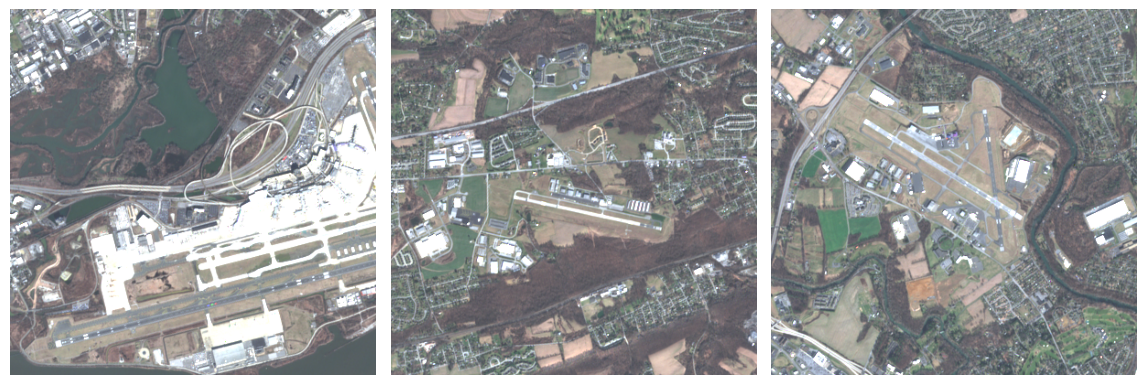

In [24]:
fig, axs = plt.subplots(1, 3, figsize=(12, 6))
fig.tight_layout(w_pad=-2)
# fig.subplots_adjust(top=0.9)
# fig.suptitle('RemoteCLIP resutls for:', fontsize=14)

for ax, img in zip(axs, imgs):
    ax.imshow(img)
    ax.axis('off')
plt.show()

In [25]:
fig.savefig('qe_s2.png', bbox_inches='tight', pad_inches=0.1)